In [66]:
import pandas as pd
DataPath = r'C:\Users\Admin\Documents\GitHub\DS-Unit-2-Applied-Modeling\Build Week\USvideos.csv'

In [67]:
def wrangle(data):
        df = pd.read_csv(DataPath)
        df.set_index(pd.to_datetime(df.trending_date, format = '%y.%d.%m'), inplace = True)
        df.drop(columns = ['trending_date',
                           'video_id',
                           'publish_time', 
                           'thumbnail_link', 
                           'comments_disabled', 
                           'ratings_disabled', 
                           'video_error_or_removed'], inplace = True)
        df_tech = df.loc[df['category_id'] == 28]
        #Drop NLP Categories for now
        df_tech.drop(columns = ['channel_title', 'category_id', 'tags', 'title', 'description'], inplace = True)
        # , 'tags', 'title', 'description'
        #df['tags'].split('|').replace('"', '')
        
        return df_tech

In [68]:
df = wrangle(DataPath)

c:\users\admin\.virtualenvs\recommender_youtube-yyrlhdk7\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [69]:
df.head()

views  likes  dislikes  comment_count
trending_date                                        
2017-11-14     119180   9763       511           1434
2017-11-14     817732  23663       778           3432
2017-11-14      75752   9419        52           1230
2017-11-14      97007  11963        36           2211
2017-11-14     224019   3585       138            208

In [6]:
df['tags'][0]

'ijustine|"week with iPhone X"|"iphone x"|"apple"|"iphone"|"iphone x review"|"iphone x unboxing"'

In [29]:
target = 'views'
X = df.drop(columns = target)
y = df[target]

In [30]:
cutoff1 = (int(0.6 * len(df)))
cutoff2 = (int(0.8 * len(df)))

In [31]:
X_train, y_train = X.iloc[:cutoff1], y.iloc[:cutoff1]
X_val, y_val = X.iloc[cutoff1:cutoff2], y.iloc[cutoff1:cutoff2]
X_test, y_test = X.iloc[cutoff2:], y.iloc[cutoff2:]

In [32]:
from sklearn.metrics import mean_absolute_error
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)
y_train_mean = y_train.mean()
print('Mean Views:', y_train_mean)
print('Baseline Mean Absolute Error:', baseline_mae)

Mean Views: 930873.8013888889
Baseline Mean Absolute Error: 977198.647650463


In [33]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
clf = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(random_state = 42)
)

clf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [34]:
train_acc = mean_absolute_error(y_train, clf.predict(X_train))
val_acc =  mean_absolute_error(y_val, clf.predict(X_val))
print('Training MAE:', train_acc)
print('Validation MAE:', val_acc)

Training MAE: 55111.26009327486
Validation MAE: 593941.2966708929


In [35]:
#!pipenv install xgboost
from category_encoders import OneHotEncoder, OrdinalEncoder
from xgboost import XGBRegressor
clf_XGB = make_pipeline(
    SimpleImputer(),
    XGBRegressor(n_estimators=100,
                   max_depth=10,
                   learning_rate=0.6,
                   n_jobs=10)
)

clf_XGB.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.6,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=10, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [36]:
train_acc_XGB = mean_absolute_error(y_train, clf_XGB.predict(X_train))
val_acc_XGB =  mean_absolute_error(y_val, clf_XGB.predict(X_val))
print('XGB Training MAE:', train_acc_XGB)
print('XGB Validation MAE:', val_acc_XGB)

XGB Training MAE: 1405.9715556674532
XGB Validation MAE: 597606.7349283855


In [38]:
param_grid = {
    'simpleimputer__strategy': ["mean", 'median'],
    'xgbregressor__max_depth': range(5, 60, 5),
    'xgbregressor__n_estimators': range(10, 120, 10)
}

In [39]:
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

model_xgb = GridSearchCV(
    clf_XGB,
    param_grid,
    cv = KFold(n_splits = 2),
    verbose = 1
)

model_xgb.fit(X_train, y_train)
test_acc_XGB = model_xgb.score(X_train, y_train)
print('Testing Score:', test_acc_XGB)

Fitting 2 folds for each of 242 candidates, totalling 484 fits
Testing Score: 0.998942869956024


In [40]:
model_xgb.best_params_

{'simpleimputer__strategy': 'mean',
 'xgbregressor__max_depth': 10,
 'xgbregressor__n_estimators': 10}

In [42]:
final_cutoff = (int(0.8 * len(df)))
X_training, y_training = X.iloc[:final_cutoff], y.iloc[:final_cutoff]
X_test, y_test = X.iloc[final_cutoff:], y.iloc[final_cutoff:]

In [44]:
model_final = make_pipeline(
    SimpleImputer(),
    XGBRegressor(n_estimators = 10,
                   max_depth = 10,
                   learning_rate = 0.6,
                   n_jobs=10)
)

model_final.fit(X_training, y_training)

training_final_acc = model_final.score(X_training, y_training)
test_final_acc =  model_final.score(X_test, y_test)
print('Training Accuracy Score:', training_final_acc)
print('Testing Accuracy Score:', test_final_acc)

Training Accuracy Score: 0.9870241945019058
Testing Accuracy Score: 0.6728122892201535


In [70]:
df.head()

views  likes  dislikes  comment_count
trending_date                                        
2017-11-14     119180   9763       511           1434
2017-11-14     817732  23663       778           3432
2017-11-14      75752   9419        52           1230
2017-11-14      97007  11963        36           2211
2017-11-14     224019   3585       138            208

In [2]:
def wrangle(data):
        df = pd.read_csv(DataPath)
        df.set_index(pd.to_datetime(df.trending_date, format = '%y.%d.%m'), inplace = True)
        df.drop(columns = ['trending_date',
                           'video_id',
                           'publish_time', 
                           'thumbnail_link', 
                           'comments_disabled', 
                           'ratings_disabled', 
                           'video_error_or_removed'], inplace = True)
        df_tech = df.loc[df['category_id'] == 28]
        #Drop NLP Categories for now
        df_tech.drop(columns = ['channel_title', 'category_id'], inplace = True)
        # , 'tags', 'title', 'description'
        #df['tags'].split('|').replace('"', '')
        
        return df_tech

In [3]:
df_tech = wrangle(DataPath)

c:\users\admin\.virtualenvs\recommender_youtube-yyrlhdk7\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
df_tech['title'][0]

'2 Weeks with iPhone X'

In [5]:
df_tech['tags'][1800]

'AsapSCIENCE|"inheritance"|"in a nutshell"|"red hair"|"why do men go bald"|"how to stop balding"|"physiology"|"colorblind test"|"balding"|"how do genetics work"|"education"|"best science videos"|"best science channel"|"mood disorder"|"what do you inherit from your mom"|"what do you inherit from your dad"|"kurzgesagt"|"animated science channel"|"chromosomes"|"genetic traits"|"eye color"|"what did I inherit from my parents"|"what did you inherit from your parents"|"night school"|"ethan\'s corner - facebook"'

In [6]:
df_tech.shape

(2401, 7)

In [7]:
df_tech.sort_values (by= ['views'], inplace=True)

In [8]:
df_tech.sort_values('views').drop_duplicates('title',keep='last')

title  \
trending_date                                                      
2018-01-22     The author of the 5:2 diet explains why eating...   
2017-12-13                                 exixe clock in action   
2017-11-14                   Sphaera - demonstrating interaction   
2018-02-05                               JavaScript Oscilloscope   
2017-11-20     Star Wars & littleBits Droid Inventor Kit: Mov...   
...                                                          ...   
2017-12-07                Liquid Sand Hot Tub- Fluidized air bed   
2017-11-24                                    What's new, Atlas?   
2018-02-08                                Intuit | A Giant Story   
2018-02-16                              Falcon Heavy Test Flight   
2018-06-01     Do You Hear Yanny or Laurel? (SOLVED with SCIE...   

                                                            tags     views  \
trending_date                                                                
2018-01-22                 Business|"Insider"|"BI"|"UK"|"Europe"      1151   
2017-12-13     STM32|"exixe"|"nixie tube"|"nixie"|"hardware"|...      1638   
2017-11-14                                                [none]      1827   
2018-02-05     JavaScript|"Oscilloscope"|"vectorscope"|"audio...      1946   
2017-11-20     littleBits|"starwars"|"inventorswanted"|"droid...      2358   
...                                                          ...       ...   
2017-12-07     fluidized bed|"liquid sand"|"fluidized sand be...  10505035   
2017-11-24     Robotics|"Humanoid Robots"|"Legged Locomotion"...  10775416   
2018-02-08     Intuit|"Powering Prosperity"|"Powering Prosper...  13312573   
2018-02-16                                                [none]  20658640   
2018-06-01     AsapSCIENCE|"audio illusion"|"yanny"|"laurel"|...  42799458   

                likes  dislikes  comment_count  \
trending_date                                    
2018-01-22         18         1              0   
2017-12-13          7         1              1   
2017-11-14          3         0              2   
2018-02-05          8         0              1   
2017-11-20         17         1              1   
...               ...       ...            ...   
2017-12-07     238584      6316          13998   
2017-11-24     205630      4927          35422   
2018-02-08      23448      8063           1794   
2018-02-16     384958     12623          38514   
2018-06-01     564804     33554         180913   

                                                     description  
trending_date                                                     
2018-01-22     Michael Mosley, author of the 5:2 diet and the...  
2017-12-13     https://github.com/dekuNukem/exixe\nhttps://gi...  
2017-11-14                                                   NaN  
2018-02-05     Generate images on an oscilloscope (vectorscop...  
2017-11-20     A kid inventor movement is afoot, with the Dro...  
...                                                          ...  
2017-12-07     Water filled hot tubs are soooo 2016. \nGo to ...  
2017-11-24               What have you been up to lately, Atlas?  
2018-02-08     In Intuit’s “A Giant Story, entrepreneur Pari ...  
2018-02-16     Following its first test launch, Falcon Heavy ...  
2018-06-01     Yanny vs. Laurel audio illusion solved! PHEW F...  

[391 rows x 7 columns]

In [9]:
df_tech['tags'][390]

'Dave2D|"Review"|"dave lee"|"mug"|"cup"|"coffee cup"|"coffee mug"|"ceramic mug"|"ember"|"starbucks"|"heater"|"phone app"|"hot mug"|"starbucks mug"|"starbucks coffee mug"|"best ceramic mug"|"best coffee mug"'

In [10]:
df_tech['tags'][390].split("|")
#.str.replace('"','')
tags_cleaned = []
for i in range(len(df_tech)):
    for tag in df_tech['tags'][i].split("|"):
        tag.replace('"', '')
        tags_cleaned.append(tag.replace('"', ''))

In [11]:
len(tags_cleaned)

41993

In [12]:
from collections import Counter
counter_tags = Counter(tags_cleaned)
Counter(tags_cleaned)


Counter({'Business': 3,
         'Insider': 3,
         'BI': 3,
         'UK': 3,
         'Europe': 3,
         'littleBits': 3,
         'starwars': 3,
         'inventorswanted': 3,
         'droid': 3,
         'thelastjedi': 3,
         'r2d2': 3,
         'r2d2toy': 3,
         'toys': 8,
         'holiday': 10,
         'giftguide': 3,
         'tech': 142,
         'education': 67,
         'forceawakens': 3,
         'STM32': 3,
         'exixe': 3,
         'nixie tube': 3,
         'nixie': 3,
         'hardware': 3,
         'arduino': 67,
         'gps': 3,
         'gnss': 3,
         'raspberry pi': 3,
         'hacker': 10,
         'IN-14': 3,
         'IN-12': 3,
         '[none]': 174,
         'JavaScript': 2,
         'Oscilloscope': 2,
         'vectorscope': 2,
         'audio': 9,
         'WAV': 2,
         'demo': 2,
         'hackaday': 5,
         'engineering': 58,
         'mechanical keyboard': 5,
         'design': 31,
         'hack': 24,
         'mak

In [13]:
sorted_values = sorted(Counter(tags_cleaned).values()) #

In [15]:
d = dict(counter_tags)

In [16]:
counter_tags = pd.DataFrame({'tags': d.keys(), 'counts': d.values()})

In [17]:
counter_tags['Percentile Rank'] = counter_tags.counts.rank(pct = True)

In [18]:
counter_tags.sort_values (by= ['Percentile Rank'], inplace=True)

In [19]:
counter_tags.head()

tags  counts  Percentile Rank
4380       iPhone ten       1         0.034848
373           arizona       1         0.034848
372   black and white       1         0.034848
1435           Boring       1         0.034848
370              hail       1         0.034848

In [20]:
#import matplotlib.pyplot as plt
counter_tags.counts.value_counts()

3      494
7      464
5      459
4      396
6      396
      ... 
125      1
209      1
58       1
62       1
91       1
Name: counts, Length: 82, dtype: int64

In [21]:
counter_tags.keys

<bound method NDFrame.keys of                  tags  counts  Percentile Rank
4380       iPhone ten       1         0.034848
373           arizona       1         0.034848
372   black and white       1         0.034848
1435           Boring       1         0.034848
370              hail       1         0.034848
...               ...     ...              ...
15               tech     142         0.999134
360        technology     152         0.999351
30             [none]     174         0.999567
1526         unboxing     209         0.999784
55            science     292         1.000000

[4620 rows x 3 columns]>

In [22]:
type(counter_tags)

pandas.core.frame.DataFrame

In [23]:
counter_tags[counter_tags['counts'] >= 4]
#counter_tags = counter_tags.drop(index=[30])
excluded = counter_tags[counter_tags['counts'] >= 6]

In [24]:
excluded

tags  counts  Percentile Rank
1536             Outer Space       6         0.471537
1529                 steamvr       6         0.471537
1530              infinadeck       6         0.471537
1541         Albert einstein       6         0.471537
1540  World Science Festival       6         0.471537
...                      ...     ...              ...
15                      tech     142         0.999134
360               technology     152         0.999351
30                    [none]     174         0.999567
1526                unboxing     209         0.999784
55                   science     292         1.000000

[2640 rows x 3 columns]

In [25]:
len(excluded)

2640

In [26]:
counter_tags.to_csv('YouTube_Recommender_1.csv', index = False)

In [28]:
# !pip install wordcloud
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [51]:
# counter_tags.info()

In [52]:
# counter_tags.head()

In [53]:
# counter_tags.sort_index(ascending = True, inplace = True)

In [54]:
# counter_tags.tail()

In [55]:
# counter_tags.to_csv('YouTube_Recommender_2.csv', index = True)

In [56]:
# counter_tags = counter_tags.drop(index=[4597])

In [57]:
# counter_tags.to_csv('YouTube_Recommender_3.csv', index = True)

In [58]:
text = " ".join(review for review in counter_tags.tags.astype(str))

In [62]:
wordcloud = WordCloud().generate(text)

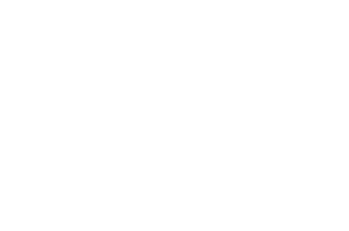

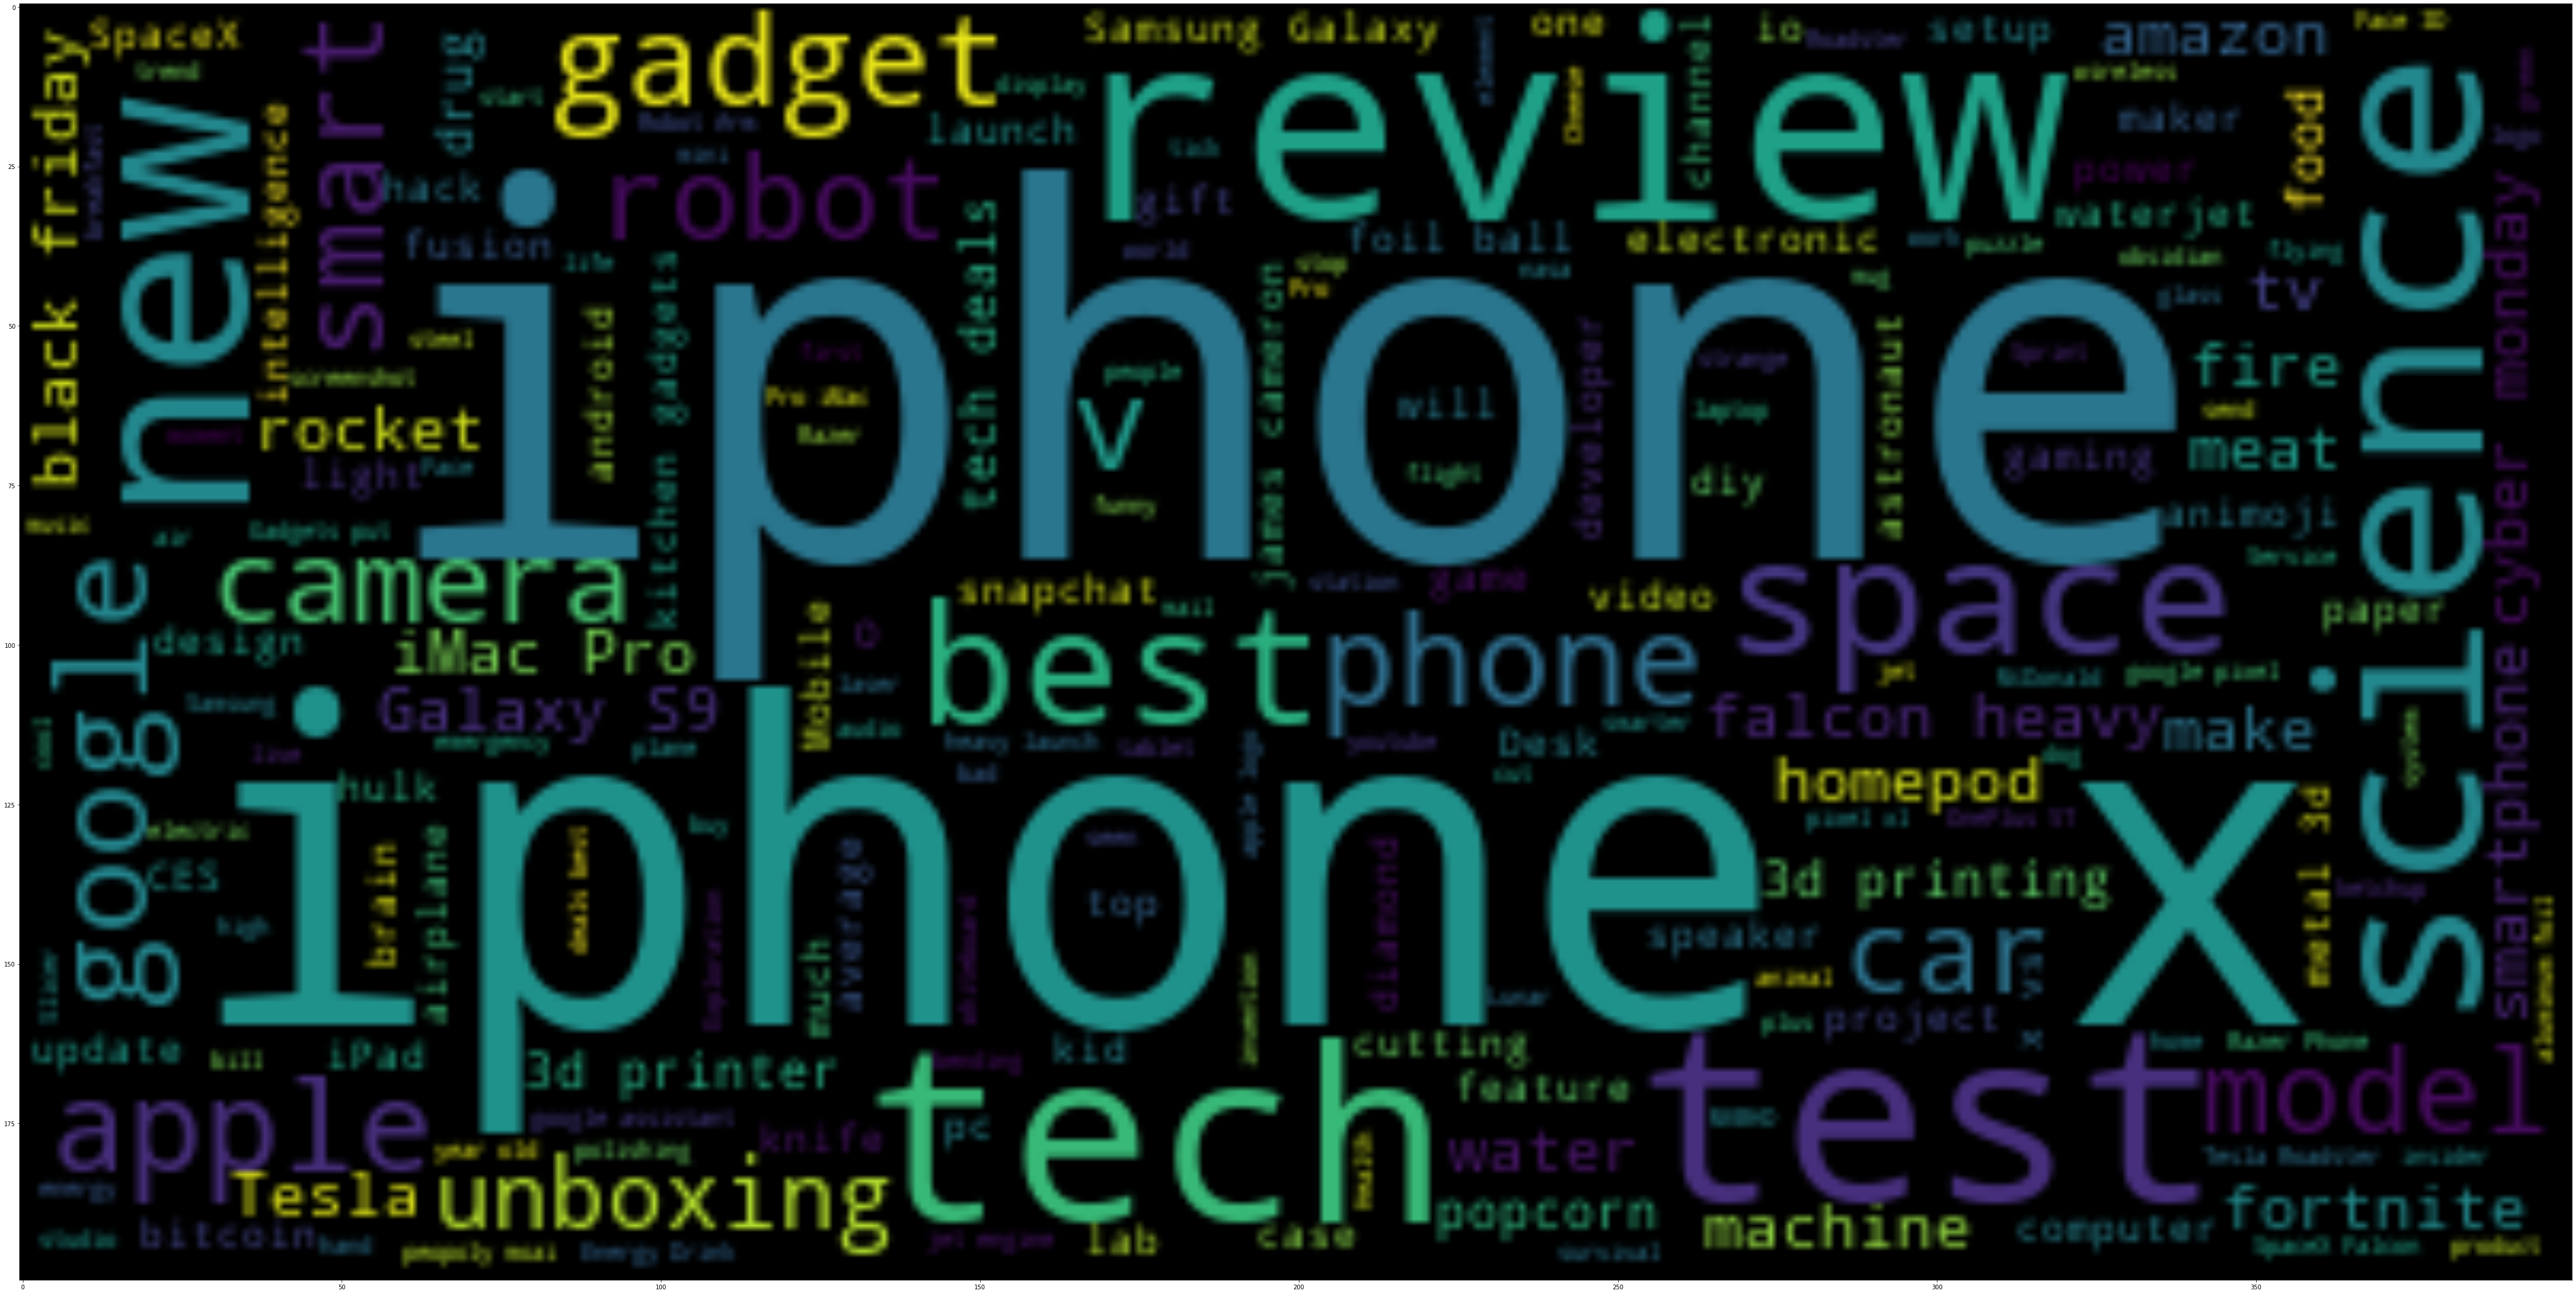

In [64]:
plt.axis("off")
plt.figure( figsize=(80,40))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()